In [31]:
import torch
import torch.nn.functional as F

from transformers import AutoModelForTokenClassification, AutoTokenizer
from datasets import load_dataset

from torch.utils.data import DataLoader

from data import CONLL
from train import train

In [32]:
dataset_hf = load_dataset('conll2003')

In [33]:
label2id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v:k for k, v in label2id.items()}

In [34]:
words = dataset_hf["train"][0]["tokens"]
labels = dataset_hf["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = id2label[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


In [4]:
model = AutoModelForTokenClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id).cuda()
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", add_prefix_space=True)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
train_dataset = CONLL(dataset_hf['train'], tokenizer)
test_dataset = CONLL(dataset_hf['test'], tokenizer)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=1)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
train(model, optimizer, 70, train_loader, val_loader)

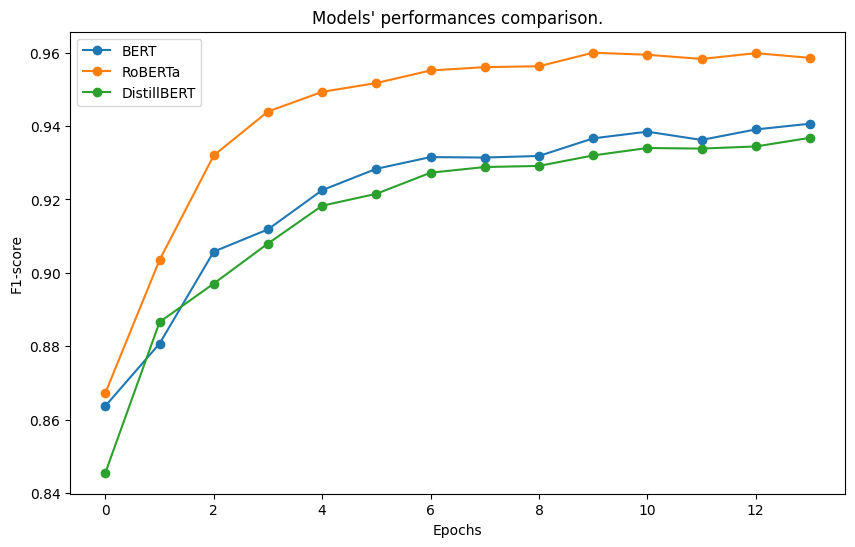

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

bert_f1 = pd.read_csv('bert_f1.csv', header=None)[2]
roberta_f1 = pd.read_csv('roberta_f1.csv', header=None)[2]
distill_f1 = pd.read_csv('distill_f1.csv', header=None)[2]

plt.figure(figsize=(10, 6))
plt.plot(bert_f1, label='BERT', marker='o')
plt.plot(roberta_f1, label='RoBERTa', marker='o')
plt.plot(distill_f1, label='DistillBERT', marker='o')
plt.xlabel('Epochs')
plt.ylabel("F1-score")
plt.title("Models' performances comparison.")
plt.legend()
plt.show()

In [19]:
tokens = torch.tensor(test_dataset[0][0]).cuda()
tags = torch.tensor(test_dataset[0][1]).cuda()

attention_mask = (tokens != 1).to(torch.uint8)

model_results = model(tokens, labels=tags, attention_mask=attention_mask)

RuntimeError: The size of tensor a (124) must match the size of tensor b (512) at non-singleton dimension 1